## 1. Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import coint
from tools.utils import download_data, get_sector_info, run_mean_reversion_analysis
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import math

C:\Users\QueLe\anaconda3\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


## 2. Functions

In [2]:
def rolling_beta(y, x, window=60):
    """
    Computes rolling hedge ratio (beta) using OLS.
    """
    betas = pd.Series(index=y.index, dtype='float64')
    for i in range(window, len(y)):
        yi = y.iloc[i - window:i]
        xi = x.iloc[i - window:i]
        if len(yi.dropna()) == window and len(xi.dropna()) == window:
            X = add_constant(xi)
            model = OLS(yi, X).fit()
            betas.iloc[i] = model.params[1]
    return betas.fillna(method='bfill')

def run_pair_trading_analysis(prices, max_pairs=50):
    tickers = prices.columns
    pairs_results = []
    spreads_dict = {}

    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            t1, t2 = tickers[i], tickers[j]
            y, x = prices[t1], prices[t2]
            y, x = y.dropna(), x.dropna()
            common_idx = y.index.intersection(x.index)
            y, x = y.loc[common_idx], x.loc[common_idx]

            if len(y) < 100:  # skip short series
                continue

            try:
                coint_pval = coint(y, x)[1]
                if coint_pval < 0.05:
                    # beta = np.polyfit(x, y, 1)[0]
                    beta = rolling_beta(y, x)
                    spread = y - beta * x
                    zscore = (spread - spread.mean()) / spread.std()
                    sharpe = (zscore.shift(1) * spread.diff()).mean() / (spread.diff().std() + 1e-8) * np.sqrt(252)

                    ticker_name = f"{t1}_{t2}"
                    pairs_results.append({
                        "Ticker": ticker_name,
                        "Stock1": t1,
                        "Stock2": t2,
                        "Cointegration p-value": round(coint_pval, 4),
                        "Sharpe (Z*ΔSpread)": round(sharpe, 4),
                        "Mean Spread": round(spread.mean(), 4),
                        "Std Spread": round(spread.std(), 4),
                        # "Start": spread.index.min(),
                        # "End": spread.index.max()
                    })
                    spreads_dict[ticker_name] = spread

            except Exception as e:
                print(f"Error processing pair ({t1}, {t2}): {e}")

    # Top pairs
    sorted_results = sorted(pairs_results, key=lambda x: x["Sharpe (Z*ΔSpread)"], reverse=True)[:max_pairs]
    pair_results_df = pd.DataFrame(sorted_results)
    # spread_df
    top_spread_series = {d["Ticker"]: spreads_dict[d["Ticker"]] for d in sorted_results}
    spread_df = pd.DataFrame(top_spread_series)
    
    return pair_results_df, spread_df


In [3]:
def benchmark_buy_and_hold(y, x, transaction_cost = 0.001):
    df = pd.concat([y, x], axis=1).dropna()
    daily_returns = df.diff().fillna(0)
    combined_returns = daily_returns.mean(axis=1)
    combined_returns.iloc[0] -= transaction_cost
    combined_returns.iloc[-1] -= transaction_cost
    cum_bench = combined_returns.cumsum()
    sharpe = combined_returns.mean() / (combined_returns.std() + 1e-8) * np.sqrt(252)
    # cum_bench = cum_bench - 2 * transaction_cost

    return {       
        "BuyHold Total Log Return": cum_bench.iloc[-1],
        "BuyHold Sharpe Ratio": sharpe,
        "BuyHold Cummulative Return": cum_bench,
    }

In [4]:
# Pair Trading Backtest Function
def backtest_pair_strategy(y, x, entry_z=1.5, exit_z=0.5, cost=0.001):
    # Align and regress to get spread
    df = pd.concat([y, x], axis=1).dropna()
    y, x = df.iloc[:, 0], df.iloc[:, 1]
    beta = rolling_beta(y, x)
    # beta = np.polyfit(x, y, 1)[0]
    spread = y - beta * x
    spread_mean = spread.rolling(60).mean().shift(-1) # to avoid lookahead bias
    spread_std = spread.rolling(60).std().shift(-1)
    zscore = (spread - spread_mean) / spread_std
    
    spread = spread.loc[zscore.index]
    beta = beta.loc[zscore.index]

    # Generate signals
    signals = pd.Series(0, index=spread.index)
    signals[zscore > entry_z] = -1  # Short spread
    signals[zscore < -entry_z] = 1  # Long spread
    signals[np.abs(zscore) < exit_z] = 0  # Exit

    # Forward fill signal positions
    positions = signals.replace(to_replace=0, method='ffill').shift(1).fillna(0)
    net_log_return = positions * spread.diff().fillna(0)
    trades = positions.diff().abs().fillna(0)
    costs = trades * cost
    net_log_return -= costs
    cum_log_return = net_log_return.cumsum()
    

    # Metrics
    sharpe = net_log_return.mean() / (net_log_return.std() + 1e-8) * np.sqrt(252)
    total_log_return = cum_log_return.iloc[-1]
    annualized_return = total_log_return * (252 / len(net_log_return))
    max_drawdown = (cum_log_return / cum_log_return.cummax() - 1).min()

    return {   
        "Total Log Return": total_log_return,
        "Annualized Return": annualized_return,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_drawdown,
        "Beta": beta,
        "Cummulative Return": cum_log_return
    }


In [5]:
def backtest_top_pairs(prices, pair_df, top_n=10):
    results = []
    for _, row in pair_df.head(top_n).iterrows():
        try:
            y = prices[row["Stock1"]]
            x = prices[row["Stock2"]]
            stats = backtest_pair_strategy(y, x)
            benchmark = benchmark_buy_and_hold(y, x)

            results.append({
                "Stock1": row["Stock1"],
                "Stock2": row["Stock2"],
                **stats,
                **benchmark
            })
        except Exception as e:
            print(f"Failed backtest for {row['Stock1']} & {row['Stock2']}: {e}")
    return pd.DataFrame(results)

In [6]:
def plot_top_pairs_grid(prices, pair_df, top_n=10, transaction_cost=0.001, title = "Top 10 Pair Trading Strategies: Cummulative Log Return"):
    n_rows = math.ceil(top_n / 2)
    n_cols = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), sharex=False)
    axes = axes.flatten()

    for idx, (_, row) in enumerate(pair_df.head(top_n).iterrows()):
        stock1, stock2 = row["Stock1"], row["Stock2"]
        y = prices[stock1]
        x = prices[stock2]

        # Use predefined strategy functions
        pair_stats = backtest_pair_strategy(y, x, cost=transaction_cost)
        bh_stats = benchmark_buy_and_hold(y, x, transaction_cost=transaction_cost)

        cum_strategy = pair_stats["Cummulative Return"]
        cum_bench = bh_stats["BuyHold Cummulative Return"]

        # Plot
        ax = axes[idx]
        ax.plot(cum_strategy, label="Pair Strategy", linewidth=2)
        ax.plot(cum_bench, label="Buy & Hold", linestyle="--", linewidth=2)
        ax.set_title(f"{stock1} vs {stock2}", fontsize=11)
        ax.legend()
        ax.grid(True)

    # Hide unused subplots
    for ax in axes[top_n:]:
        ax.set_visible(False)

    fig.suptitle(title, fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(f"../modelling_result/plots_{title}_{start_date[:4]}_{end_date[:4]}")
    plt.show()

In [7]:
def build_pair_metadata(pair_results_df, metadata_df):
    # Make metadata_df searchable
    meta = metadata_df.set_index("Stock")

    records = []
    for _, row in pair_results_df.iterrows():
        t1, t2 = row["Stock1"], row["Stock2"]
        ticker_pair = row["Ticker"]

        # Get sector/cap info safely
        sector1 = meta.loc[t1]["Sector"] if t1 in meta.index else "N/A"
        sector2 = meta.loc[t2]["Sector"] if t2 in meta.index else "N/A"
        industry1 = meta.loc[t1]["Industry"] if t1 in meta.index else "N/A"
        industry2 = meta.loc[t2]["Industry"] if t2 in meta.index else "N/A"
        cap1 = meta.loc[t1]["CapSize"] if t1 in meta.index else "N/A"
        cap2 = meta.loc[t2]["CapSize"] if t2 in meta.index else "N/A"

        records.append({
            "Ticker": ticker_pair,
            "Stock1": t1,
            "Stock2": t2,
            "Sector1": sector1,
            "Sector2": sector2,
            "Industry1": industry1,
            "Industry2": industry2,
            "CapSize1": cap1,
            "CapSize2": cap2,
            # "CombinedSector": f"{sector1}_{sector2}"
        })

    return pd.DataFrame(records)

In [8]:
def add_metadata_to_pairs(df, metadata_df):
    """
    Adds sector/industry/cap size data for Stock1 and Stock2 to a pairs DataFrame.
    """
    # Merge metadata for Stock1
    df = df.merge(
        metadata_df[['Stock', 'Sector', 'Industry', 'CapSize']],
        left_on='Stock1',
        right_on='Stock',
        how='left'
    ).rename(columns={
        'Sector': 'Sector1',
        'Industry': 'Industry1',
        'CapSize': 'CapSize1'
    }).drop(columns='Stock')
    
    # Merge metadata for Stock2
    df = df.merge(
        metadata_df[['Stock', 'Sector', 'Industry', 'CapSize']],
        left_on='Stock2',
        right_on='Stock',
        how='left'
    ).rename(columns={
        'Sector': 'Sector2',
        'Industry': 'Industry2',
        'CapSize': 'CapSize2'
    }).drop(columns='Stock')
    
    # Add pair-level flags
    df['Same_Sector'] = df['Sector1'] == df['Sector2']
    df['Same_Industry'] = df['Industry1'] == df['Industry2']
    
    return df

In [9]:
def calculate_sector_industry_correlation_matrix(price_df, sector_etfs, industry_etfs, level='Sector'):
    ticker_to_sector = {v: k for k, v in sector_etfs.items()}
    ticker_to_industry = {v: k for k, v in industry_etfs.items()}
    if level == 'Sector':
        mapping = ticker_to_sector
    elif level == 'Industry':
        mapping = ticker_to_industry
    else:
        raise ValueError("level must be either 'Sector' or 'Industry'")

    # Select relevant ETFs
    common_cols = [col for col in price_df.columns if col in mapping]
    data = price_df[common_cols].copy()

    # Compute returns
    returns = data.pct_change().dropna()

    # Rename columns to descriptive names (Sector/Industry)
    returns.columns = [mapping[col] for col in returns.columns]

    # Compute correlation matrix
    corr_matrix = returns.corr()

    # Convert to long-form and clean
    correlation_df = corr_matrix.reset_index().melt(id_vars='index')
    correlation_df.columns = [f'{level}1', f'{level}2', f'{level} Correlation']
    correlation_df = correlation_df[correlation_df[f'{level}1'] != correlation_df[f'{level}2']]

    # Remove duplicate unordered pairs
    correlation_df['PairKey'] = correlation_df.apply(
        lambda row: frozenset([row[f'{level}1'], row[f'{level}2']]), axis=1
    )
    correlation_df = correlation_df.drop_duplicates(subset='PairKey').drop(columns='PairKey')

    return correlation_df


def add_correlation_column(pair_df, correlation_df, level='Sector'):
    df = pair_df.copy()

    # Dynamically assign key column names
    col1 = f"{level}1"
    col2 = f"{level}2"
    key_col = f"{level}PairKey"
    corr_col = f"{level} ETF Correlation"
    corr_cate_col = f"{level} Correlation Category"

    # Create unordered pair keys in both dataframes
    df[key_col] = df.apply(lambda row: frozenset([row[col1], row[col2]]), axis=1)
    correlation_df[key_col] = correlation_df.apply(lambda row: frozenset([row[col1], row[col2]]), axis=1)

    # Drop duplicates from correlation_df
    correlation_df = correlation_df.drop_duplicates(subset=key_col)

    # Create a lookup map from the correlation DataFrame
    corr_map = dict(zip(correlation_df[key_col], correlation_df[f'{level} Correlation']))
    df[corr_col] = df[key_col].map(corr_map)

    # Classify the correlation strength
    def classify_corr(corr):
        if pd.isna(corr):
            return 'Unknown'
        elif corr >= 0.7:
            return 'Highly Correlated'
        elif corr >= 0.3:
            return 'Moderately Correlated'
        elif corr <= -0.3:
            return 'Inversely Correlated'
        else:
            return 'Uncorrelated'

    df[corr_cate_col] = df[corr_col].apply(classify_corr)

    return df.drop(columns=key_col)


def plot_correlation_distribution(win_df, lose_df, level='Industry', save_path=None):
    corr_col = f"{level} ETF Correlation"

    sns.set(style='whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    sns.histplot(win_df[corr_col], ax=axes[0], kde=True, color='salmon')
    axes[0].set_title(f'{level} Correlation Distribution in Win Cases')

    sns.histplot(lose_df[corr_col], ax=axes[1], kde=True, color='salmon')
    axes[1].set_title(f'{level} Correlation Distribution in Lose Cases')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


## 3. Parameters

In [10]:
start_date = '2010-01-01'
end_date = '2019-12-31'
large_cap_tickers = ['AAPL', 'MSFT', 'JPM', 'NVDA', 'XOM', 'JNJ', 'UNH', 'PG', 'V', 'MA', 'HD', 'COST', 'AVGO', 'LLY', 'BAC', 'MRK', 'ADBE']
mid_cap_tickers = ['TFX', 'HES', 'NTNX', 'WU', 'FIVE', 'GNRC', 'WING', 'CHDN', 'FND', 'HWM', 'CROX', 'ENPH', 'FICO', 'ROK', 'LII']
small_cap_tickers = ['INSM', 'NEOG', 'ACLS', 'PRDO', 'ORGO', 'IMMR', 'CVCO', 'GPRO', 'STRL', 'TPC', 'GHC', 'FIZZ', 'EVTC', 'CMTL', 'MGEE']
tickers = large_cap_tickers + mid_cap_tickers + small_cap_tickers
window_list = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144]

In [11]:
prices = download_data(tickers, start_date, end_date)
prices.head()

Failed to get ticker 'GPRO' reason: Expecting value: line 1 column 1 (char 0)
[                       0%%                      ]Failed to get ticker 'CROX' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'MGEE' reason: Expecting value: line 1 column 1 (char 0)
[**                     4%%                      ]  2 of 47 completedFailed to get ticker 'XOM' reason: Expecting value: line 1 column 1 (char 0)
[***                    6%%                      ]  3 of 47 completedFailed to get ticker 'TFX' reason: Expecting value: line 1 column 1 (char 0)
[****                   9%%                      ]  4 of 47 completedFailed to get ticker 'HWM' reason: Expecting value: line 1 column 1 (char 0)
[*****                 11%%                      ]  5 of 47 completedFailed to get ticker 'LLY' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'ENPH' reason: Expecting value: line 1 column 1 (char 0)
[******                13%%                      ]  6 

Yahoo Finance returned no data. Falling back to local CSV.
NTNX not found in local CSV.
FIVE not found in local CSV.
GNRC not found in local CSV.
WING not found in local CSV.
FND not found in local CSV.
HWM not found in local CSV.
ENPH not found in local CSV.
ORGO not found in local CSV.
GPRO not found in local CSV.
EVTC not found in local CSV.


,AAPL,MSFT,JPM,NVDA,XOM,JNJ,UNH,PG,V,MA,...,ACLS,PRDO,IMMR,CVCO,STRL,TPC,GHC,FIZZ,CMTL,MGEE
0,1.862580,3.146479,3.361388,-0.858297,3.661610,3.721465,3.222706,3.668499,2.983252,3.164680,...,1.757858,3.109017,1.449828,3.623007,2.967847,2.880637,5.365736,1.260585,3.156317,2.791282
1,1.864307,3.146802,3.380573,-0.843800,3.665507,3.709802,3.221119,3.668826,2.971727,3.161716,...,1.743969,3.108588,1.458394,3.590991,2.973998,2.901366,5.368628,1.235893,3.154628,2.761194
2,1.848273,3.140647,3.386052,-0.837423,3.674113,3.717903,3.230919,3.664071,2.958208,3.160269,...,1.798404,3.126453,1.479491,3.555348,2.982140,2.924762,5.370003,1.212228,3.150392,2.760623
3,1.846423,3.130193,3.405667,-0.857215,3.670966,3.710740,3.268578,3.658634,2.967472,3.153713,...,1.805005,3.144005,1.487808,3.594294,2.991724,2.981692,5.392476,1.202269,3.165278,2.760337
4,1.853049,3.137065,3.403209,-0.855057,3.666946,3.714172,3.259142,3.657311,2.970234,3.154068,...,1.874874,3.159216,1.502196,3.627802,2.980619,3.005674,5.392476,1.201435,3.196295,2.766603


In [12]:
etf_sector_tickers = ['XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK', 'XLU']
etf_industry_tickers = ['FDN','IGV','KBE','SOXX','XLE','PJP','IHF','XLP','IPAY','XRT','XLY','WCLD','IHI','XOP','RETL','XAR','PBI','BJK','ITA','TAN','PKB','XBI','SMH','ITB','XLU']
sector_etfs = {
    'Consumer Cyclical': 'XLY',
    'Consumer Defensive': 'XLP',
    'Financial Services': 'XLF',
    'Healthcare': 'XLV',
    'Industrials': 'XLI',
    'Technology': 'XLK',
    'Utilities': 'XLU',
    'Real Estate': 'XLRE',
    'Energy': 'XLE',
    'Basic Materials': 'XLB',
    'Communication Services': 'XLC',
}

industry_etfs = {
    'Consumer Electronics': 'FDN',
    'Software - Infrastructure': 'IGV',
    'Banks - Diversified': 'KBE',
    'Semiconductors': 'SOXX',
    'Oil & Gas Integrated': 'XLE',
    'Drug Manufacturers - General': 'PJP',
    'Healthcare Plans': 'IHF',
    'Household & Personal Products': 'XLP',
    'Credit Services': 'IPAY',
    'Home Improvement Retail': 'XRT',
    'Discount Stores': 'XLY',
    'Software - Application': 'WCLD',
    'Medical Instruments & Supplies': 'IHI',
    'Oil & Gas E&P': 'XOP',
    'Specialty Retail': 'RETL',
    'Specialty Industrial Machinery': 'XAR',
    'Restaurants': 'PBI',
    'Gambling': 'BJK',
    'Aerospace & Defense': 'ITA',
    'Solar': 'TAN',
    'Building Products & Equipment': 'PKB',
    'Biotechnology': 'XBI',
    'Semiconductor Equipment & Materials': 'SMH',
    'Residential Construction': 'ITB',
    'Utilities - Regulated Electric': 'XLU'
}

In [13]:
# metadata
ticker_cap_mapping = {ticker: 'Large' for ticker in large_cap_tickers}
ticker_cap_mapping.update({ticker: 'Mid' for ticker in mid_cap_tickers})
ticker_cap_mapping.update({ticker: 'Small' for ticker in small_cap_tickers})

# sector_df = get_sector_info(tickers)
# sector_df['CapSize'] = sector_df['Ticker'].map(ticker_cap_mapping)
# metadata_df = sector_df[['Ticker', 'Sector', 'Industry', 'CapSize']]
metadata_df = pd.read_csv("../data_prices/metadata.csv")
metadata_df = metadata_df.rename(columns={'Ticker': 'Stock'})
metadata_df

,Stock,Sector,Industry,CapSize
0,AAPL,Technology,Consumer Electronics,Large
1,MSFT,Technology,Software - Infrastructure,Large
2,JPM,Financial Services,Banks - Diversified,Large
3,NVDA,Technology,Semiconductors,Large
4,XOM,Energy,Oil & Gas Integrated,Large
5,JNJ,Healthcare,Drug Manufacturers - General,Large
6,UNH,Healthcare,Healthcare Plans,Large
7,PG,Consumer Defensive,Household & Personal Products,Large
8,V,Financial Services,Credit Services,Large
9,MA,Financial Services,Credit Services,Large


## 4. Analysis

In [14]:
# Cointegration analysis
# pair_results_df, pair_spread = run_pair_trading_analysis(prices)
pair_results_df = pd.read_csv(f"../modelling_result/pair_trading_top_cointegrated_pairs_{start_date[:4]}_{end_date[:4]}.csv")
pair_spread = pd.read_csv(f"../modelling_result/pair_trading_spread_series_{start_date[:4]}_{end_date[:4]}.csv")
# pair_results_df.to_csv(f"../modelling_result/pair_trading_top_cointegrated_pairs_{start_date[:4]}_{end_date[:4]}.csv", index=False)
# pair_spread.to_csv(f"../modelling_result/pair_trading_spread_series_{start_date[:4]}_{end_date[:4]}.csv", index=False)

In [15]:
pair_results_df.head()

,Ticker,Stock1,Stock2,Cointegration p-value,Sharpe (Z*ΔSpread),Mean Spread,Std Spread,Start,End
0,UNH_NEOG,UNH,NEOG,0.0147,-0.1177,3.6743,1.4244,0,2514
1,UNH_CVCO,UNH,CVCO,0.0020,-0.1942,3.7287,1.7429,0,2514
2,UNH_AVGO,UNH,AVGO,0.0344,-0.2148,3.9832,0.9568,0,2514
3,UNH_CHDN,UNH,CHDN,0.0422,-0.2672,3.5605,1.5493,0,2514
4,ROK_CVCO,ROK,CVCO,0.0039,-0.2720,3.0862,2.0004,0,2514


In [16]:
pair_spread.head()

,UNH_NEOG,UNH_CVCO,UNH_AVGO,UNH_CHDN,ROK_CVCO,ROK_NEOG,HD_NEOG,V_HD,JNJ_NEOG,COST_CHDN,...,CHDN_CVCO,MSFT_CVCO,AAPL_MRK,MSFT_TFX,NEOG_CVCO,V_MRK,PG_MRK,JNJ_CVCO,WU_FICO,JPM_ROK
0,3.102292,2.850937,3.214277,3.089163,2.972740,2.116989,1.552586,1.605142,3.401892,3.739331,...,0.326542,1.876229,0.438321,2.937603,-0.770642,2.798044,4.254193,3.147425,3.263140,2.328641
1,3.102565,2.852636,3.212476,3.089534,2.969851,2.131134,1.582122,1.590256,3.395165,3.736389,...,0.313435,1.887777,0.438162,2.938505,-0.775769,2.786273,4.255296,3.140834,3.256253,2.350150
2,3.113100,2.866093,3.222046,3.100537,2.994363,2.158723,1.587454,1.578334,3.405219,3.749362,...,0.311675,1.894118,0.415896,2.931810,-0.761456,2.771944,4.253104,3.154583,3.256719,2.350153
3,3.150023,2.899755,3.259888,3.138546,2.999078,2.160888,1.590398,1.582189,3.396103,3.744533,...,0.291706,1.870009,0.413302,2.920859,-0.778119,2.781111,4.247972,3.141249,3.288603,2.366590
4,3.140362,2.886881,3.250239,3.128842,3.007580,2.172055,1.582891,1.587171,3.398939,3.737293,...,0.282012,1.865134,0.420176,2.927414,-0.798581,2.783905,4.246547,3.139373,3.297679,2.360105


### 4.1. Statistical test on spreads

In [17]:
# Statistical Mean Reversion Analysis
pair_metadata_df = build_pair_metadata(pair_results_df, metadata_df)
pair_metadata_df

,Ticker,Stock1,Stock2,Sector1,Sector2,Industry1,Industry2,CapSize1,CapSize2
0,UNH_NEOG,UNH,NEOG,Healthcare,Healthcare,Healthcare Plans,Diagnostics & Research,Large,Small
1,UNH_CVCO,UNH,CVCO,Healthcare,Consumer Cyclical,Healthcare Plans,Residential Construction,Large,Small
2,UNH_AVGO,UNH,AVGO,Healthcare,Technology,Healthcare Plans,Semiconductors,Large,Large
3,UNH_CHDN,UNH,CHDN,Healthcare,Consumer Cyclical,Healthcare Plans,Gambling,Large,Mid
4,ROK_CVCO,ROK,CVCO,Industrials,Consumer Cyclical,Specialty Industrial Machinery,Residential Construction,Mid,Small
5,ROK_NEOG,ROK,NEOG,Industrials,Healthcare,Specialty Industrial Machinery,Diagnostics & Research,Mid,Small
6,HD_NEOG,HD,NEOG,Consumer Cyclical,Healthcare,Home Improvement Retail,Diagnostics & Research,Large,Small
7,V_HD,V,HD,Financial Services,Consumer Cyclical,Credit Services,Home Improvement Retail,Large,Large
8,JNJ_NEOG,JNJ,NEOG,Healthcare,Healthcare,Drug Manufacturers - General,Diagnostics & Research,Large,Small
9,COST_CHDN,COST,CHDN,Consumer Defensive,Consumer Cyclical,Discount Stores,Gambling,Large,Mid


In [18]:
stat_df = run_mean_reversion_analysis(pair_spread, pair_metadata_df, strategy_type="spread")
stat_df

,Ticker,ADF p-value,Hurst,Half-life,Volatility,Stock1,Stock2,Sector1,Sector2,Industry1,Industry2,CapSize1,CapSize2
0,UNH_NEOG,0.0000,0.4825,962.3880,0.1378,UNH,NEOG,Healthcare,Healthcare,Healthcare Plans,Diagnostics & Research,Large,Small
1,UNH_CVCO,0.0000,0.5105,605.0960,0.1624,UNH,CVCO,Healthcare,Consumer Cyclical,Healthcare Plans,Residential Construction,Large,Small
2,UNH_AVGO,0.0000,0.5118,606.8365,0.0805,UNH,AVGO,Healthcare,Technology,Healthcare Plans,Semiconductors,Large,Large
3,UNH_CHDN,0.0000,0.5206,510.5658,0.1246,UNH,CHDN,Healthcare,Consumer Cyclical,Healthcare Plans,Gambling,Large,Mid
4,ROK_CVCO,0.0000,0.4715,491.9301,0.1641,ROK,CVCO,Industrials,Consumer Cyclical,Specialty Industrial Machinery,Residential Construction,Mid,Small
5,ROK_NEOG,0.0000,0.5278,414.2439,0.1445,ROK,NEOG,Industrials,Healthcare,Specialty Industrial Machinery,Diagnostics & Research,Mid,Small
6,HD_NEOG,0.0000,0.5249,408.3082,0.1166,HD,NEOG,Consumer Cyclical,Healthcare,Home Improvement Retail,Diagnostics & Research,Large,Small
7,V_HD,0.0000,0.4008,305.8603,0.1875,V,HD,Financial Services,Consumer Cyclical,Credit Services,Home Improvement Retail,Large,Large
8,JNJ_NEOG,0.0000,0.4455,271.9072,0.0885,JNJ,NEOG,Healthcare,Healthcare,Drug Manufacturers - General,Diagnostics & Research,Large,Small
9,COST_CHDN,0.0000,0.4588,312.5358,0.1107,COST,CHDN,Consumer Defensive,Consumer Cyclical,Discount Stores,Gambling,Large,Mid


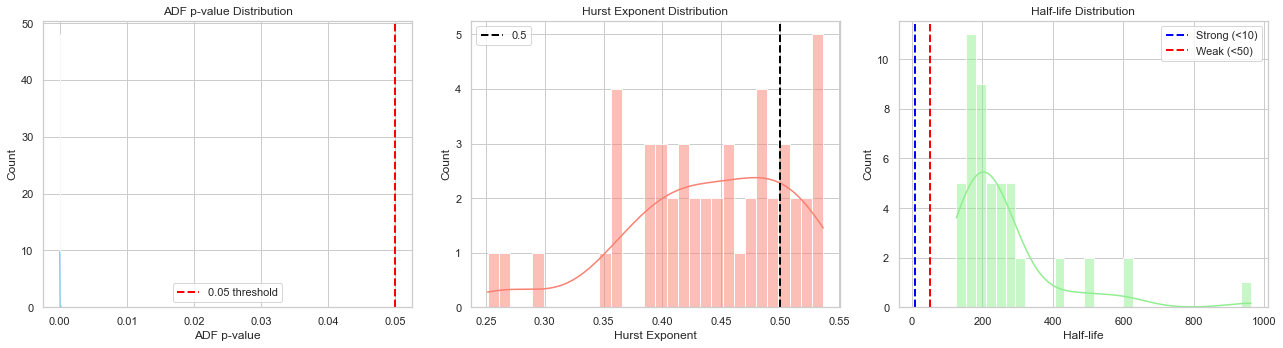

In [19]:
# Plotting histograms for ADF p-value, Hurst exponent, and Half-life
df = stat_df.copy()

# Set style
sns.set(style='whitegrid')

# Set up the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram for ADF p-value with threshold
sns.histplot(df['ADF p-value'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].axvline(0.05, color='red', linestyle='--', linewidth=2, label='0.05 threshold')
axes[0].set_title('ADF p-value Distribution')
axes[0].set_xlabel('ADF p-value')
axes[0].legend()

# Histogram for Hurst exponent with thresholds
sns.histplot(df['Hurst'], bins=30, kde=True, ax=axes[1], color='salmon')
axes[1].axvline(0.5, color='black', linestyle='--', linewidth=2, label='0.5')
axes[1].set_title('Hurst Exponent Distribution')
axes[1].set_xlabel('Hurst Exponent')
axes[1].legend()

# Histogram for Half-life with thresholds
sns.histplot(df['Half-life'], bins=30, kde=True, ax=axes[2], color='lightgreen')
axes[2].axvline(10, color='blue', linestyle='--', linewidth=2, label='Strong (<10)')
axes[2].axvline(50, color='red', linestyle='--', linewidth=2, label='Weak (<50)')
axes[2].set_title('Half-life Distribution')
axes[2].set_xlabel('Half-life')
axes[2].legend()

# Final layout
plt.tight_layout()
plt.savefig(f"../modelling_result/plots_spread_distribution")
plt.show()

### 4.2. Backtesting strategy

In [20]:
# Backtesting
# pair_backtest_df = backtest_top_pairs(prices, pair_results_df, top_n=48)
# pair_backtest_df.to_csv(f"../modelling_result/pair_trading_backtest_results_{start_date[:4]}_{end_date[:4]}.csv", index=False)
pair_backtest_df = pd.read_csv(f"../modelling_result/pair_trading_backtest_results_{start_date[:4]}_{end_date[:4]}.csv")
pair_backtest_df['Ticker'] = pair_backtest_df['Stock1'] + '_' + pair_backtest_df['Stock2']

In [21]:
# Divide into winning group and losing group
win = pair_backtest_df[(pair_backtest_df['Total Log Return'] > pair_backtest_df['BuyHold Total Log Return']) & (pair_backtest_df['Sharpe Ratio'] >= pair_backtest_df['BuyHold Sharpe Ratio'])]
lose = pair_backtest_df[~pair_backtest_df.index.isin(win.index)]

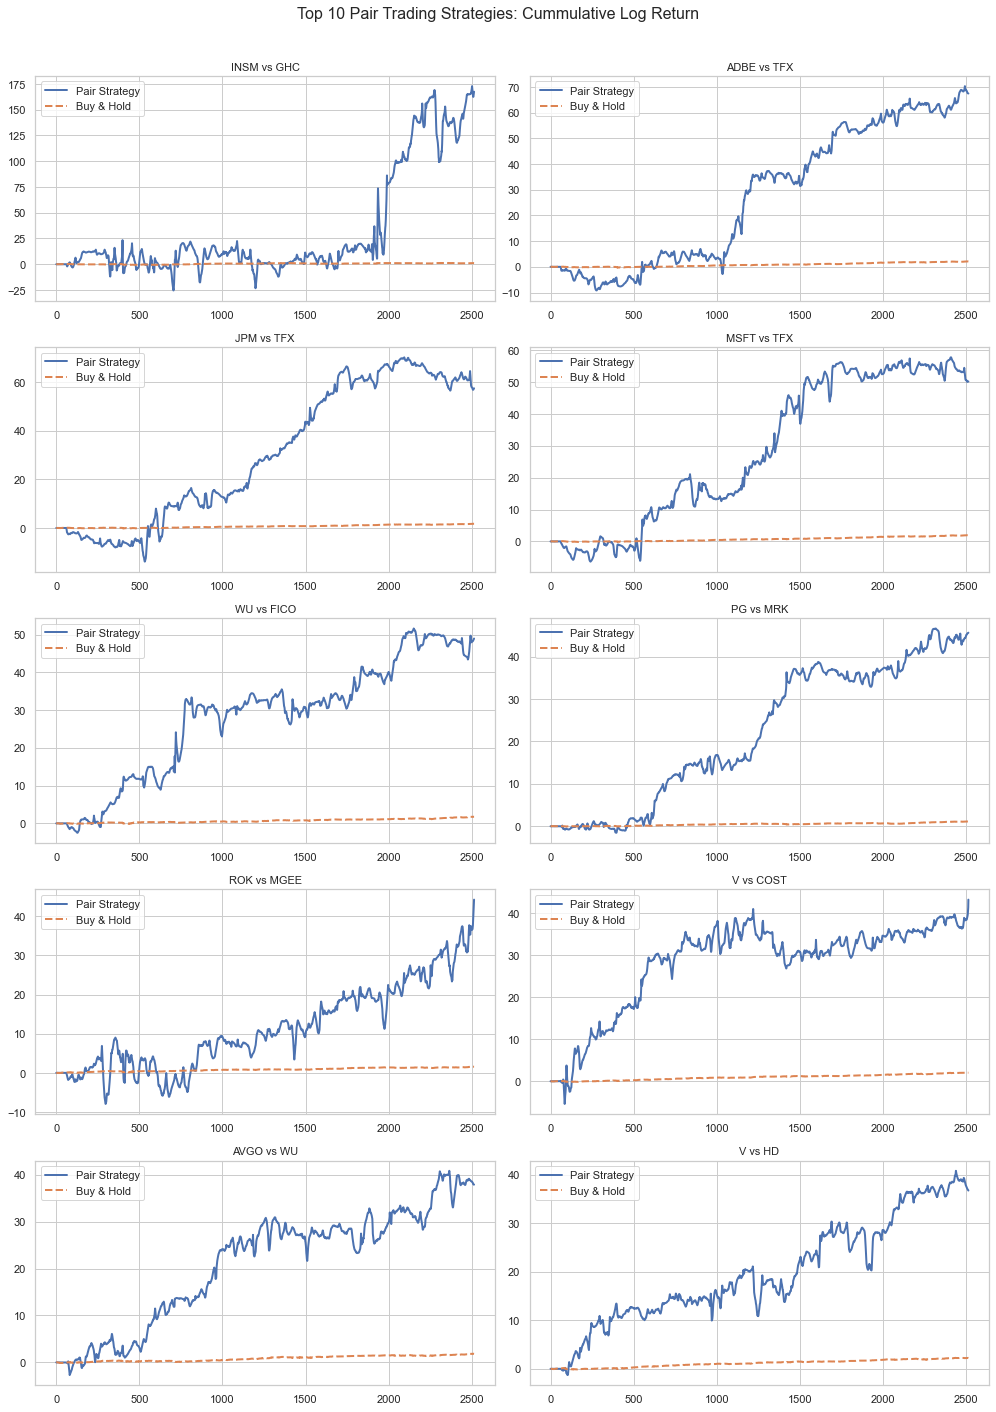

In [22]:
top10 = win.sort_values('Total Log Return', ascending=False).head(10)
plot_top_pairs_grid(prices, top10, top_n=10, title = "Top 10 Pair Trading Strategies: Cummulative Log Return")

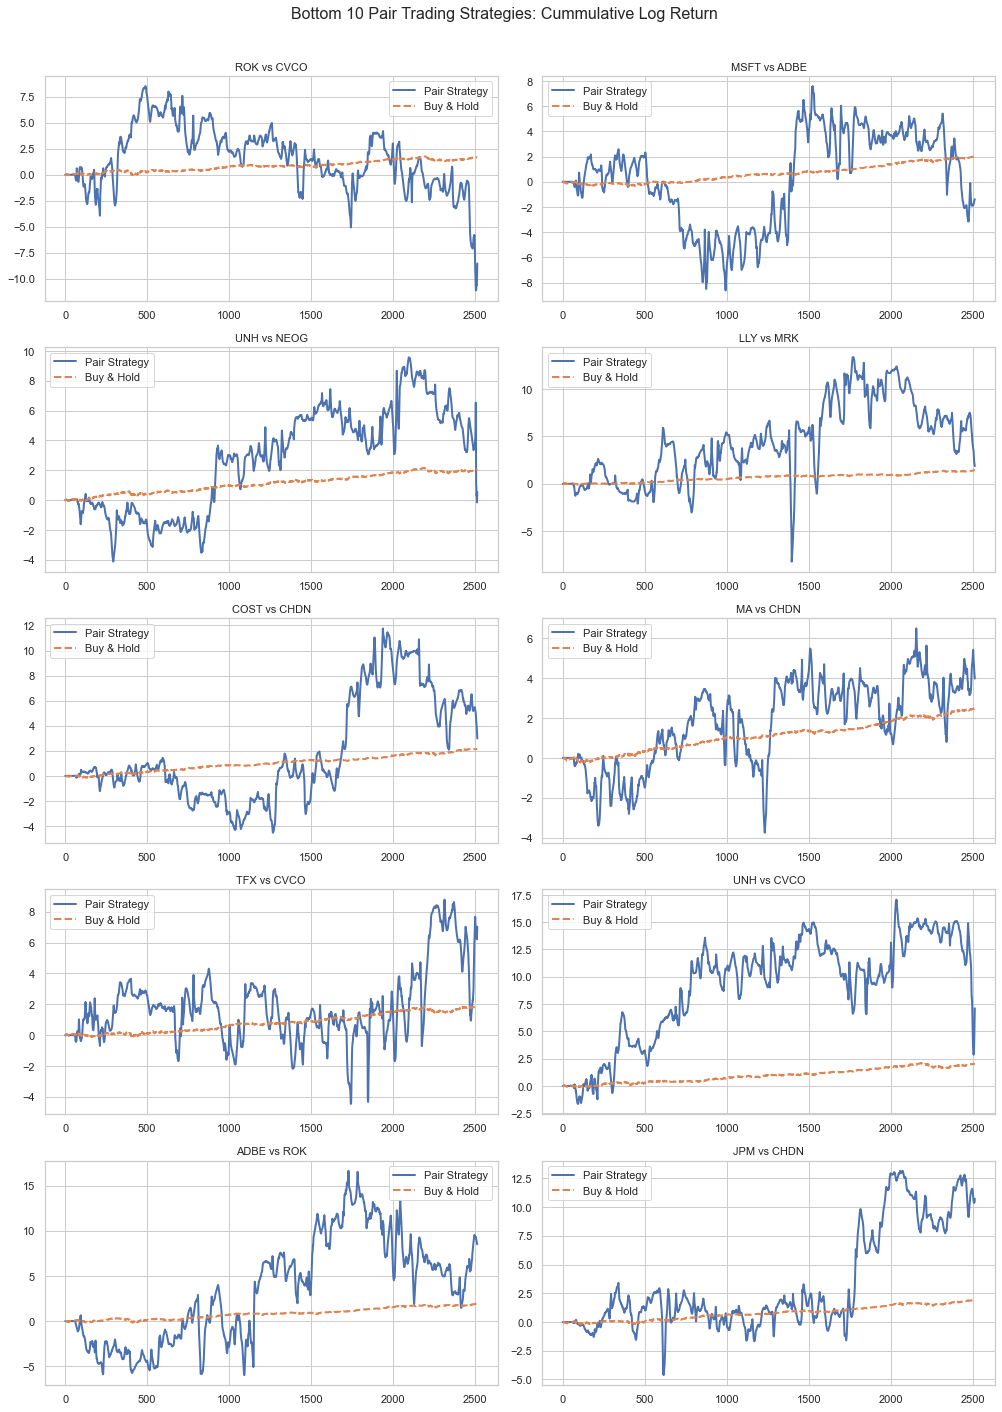

In [23]:
bottom10 = lose.sort_values('Total Log Return', ascending=True).head(10)
plot_top_pairs_grid(prices, bottom10, top_n=10, title = "Bottom 10 Pair Trading Strategies: Cummulative Log Return")

#### a. Sector and Industry Analysis

In [24]:
win = top10.copy()
lose = bottom10.copy()

In [25]:
# etf_sector_data = yf.download(etf_sector_tickers, start='2010-01-01', end='2019-12-31', auto_adjust=True)['Close']
# etf_industry_data = yf.download(etf_industry_tickers, start='2010-01-01', end='2019-12-31', auto_adjust=True)['Close']
etf_sector_data = pd.read_csv(f"../data_prices/etf_sector_data_{start_date[:4]}_{end_date[:4]}.csv")
etf_industry_data = pd.read_csv(f"../data_prices/etf_industry_data_{start_date[:4]}_{end_date[:4]}.csv")

# etf_sector_data['Close'].to_csv(f"../data_prices/etf_sector_data_{start_date[:4]}_{end_date[:4]}.csv")
# etf_industry_data['Close'].to_csv(f"../data_prices/etf_industry_data_{start_date[:4]}_{end_date[:4]}.csv")
etf_sector_data = etf_sector_data.fillna(method='bfill')
etf_industry_data = etf_industry_data.fillna(method='bfill')

In [26]:
win_with_metadata = add_metadata_to_pairs(win, metadata_df)
lose_with_metadata = add_metadata_to_pairs(lose, metadata_df)

win_with_metadata['label'] = 'Win'
lose_with_metadata['label'] = 'Lose'

df_all = pd.concat([win_with_metadata, lose_with_metadata], ignore_index=True)

In [27]:
df_all['Sector_Pair'] = df_all[['Sector1', 'Sector2']].apply(lambda x: ' vs. '.join(sorted([x[0], x[1]])), axis=1)
sector_summary = (
    df_all
    .groupby(['Sector_Pair', 'label'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={'Win': 'Win_Count', 'Lose': 'Lose_Count'})
)
sector_summary

label,Sector_Pair,Lose_Count,Win_Count
0,Consumer Cyclical vs. Consumer Defensive,1,0
1,Consumer Cyclical vs. Financial Services,2,1
2,Consumer Cyclical vs. Healthcare,2,0
3,Consumer Cyclical vs. Industrials,1,0
4,Consumer Defensive vs. Financial Services,0,1
5,Consumer Defensive vs. Healthcare,0,2
6,Financial Services vs. Healthcare,0,1
7,Financial Services vs. Technology,0,2
8,Healthcare vs. Healthcare,2,0
9,Healthcare vs. Technology,0,2


In [28]:
df_all['Industry_Pair'] = df_all[['Industry1', 'Industry2']].apply(lambda x: ' vs. '.join(sorted([x[0], x[1]])), axis=1)
industry_summary = (
    df_all
    .groupby(['Industry_Pair', 'label'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={'Win': 'Win_Count', 'Lose': 'Lose_Count'})
)
industry_summary

label,Industry_Pair,Lose_Count,Win_Count
0,Banks - Diversified vs. Gambling,1,0
1,Banks - Diversified vs. Medical Instruments & ...,0,1
2,Biotechnology vs. Education & Training Services,0,1
3,Credit Services vs. Discount Stores,0,1
4,Credit Services vs. Gambling,1,0
5,Credit Services vs. Home Improvement Retail,0,1
6,Credit Services vs. Semiconductors,0,1
7,Credit Services vs. Software - Application,0,1
8,Diagnostics & Research vs. Healthcare Plans,1,0
9,Discount Stores vs. Gambling,1,0


In [29]:
sector_correlation_df = calculate_sector_industry_correlation_matrix(etf_sector_data, sector_etfs, industry_etfs, level='Sector')
industry_correlation_df = calculate_sector_industry_correlation_matrix(etf_industry_data, sector_etfs, industry_etfs, level='Industry')
# stat_df
redundant_cols = ['Sector1', 'Sector2', 'Industry1', 'Industry2', 'CapSize1', 'CapSize2']
stat_df = stat_df.drop(columns=redundant_cols, errors='ignore')

In [30]:
# Sector
win_with_corr_sector = add_correlation_column(win_with_metadata, sector_correlation_df, level='Sector')
lose_with_corr_sector = add_correlation_column(lose_with_metadata, sector_correlation_df, level='Sector')

In [31]:
# merge with stat_df
lose_with_corr_sector = lose_with_corr_sector.merge(stat_df[['Ticker', 'ADF p-value', 'Hurst', 'Half-life', 'Volatility']], on='Ticker', how='left')
win_with_corr_sector = win_with_corr_sector.merge(stat_df[['Ticker', 'ADF p-value', 'Hurst', 'Half-life', 'Volatility']], on='Ticker', how='left')

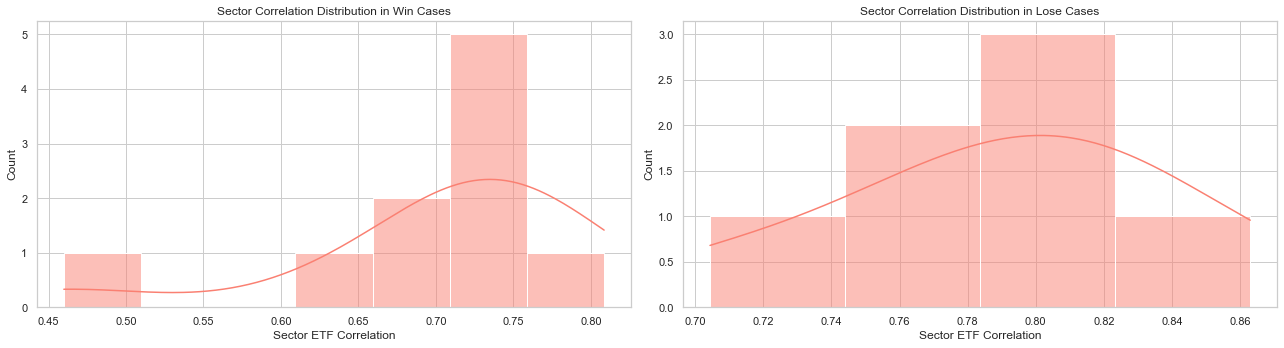

In [32]:
plot_correlation_distribution(win_with_corr_sector, lose_with_corr_sector, level='Sector',
                              save_path="../modelling_result/plot_etf_sector_distribution.png")

In [33]:
# Industry
win_with_corr_industry = add_correlation_column(win_with_metadata, industry_correlation_df, level='Industry')
lose_with_corr_industry = add_correlation_column(lose_with_metadata, industry_correlation_df, level='Industry')

In [34]:
# merge with stat_df
lose_with_corr_industry['Ticker'] = lose_with_corr_industry['Stock1'] + '_' + lose_with_corr_industry['Stock2']
lose_with_corr_industry = lose_with_corr_industry.merge(stat_df, on='Ticker', how='left')
win_with_corr_industry['Ticker'] = win_with_corr_industry['Stock1'] + '_' + win_with_corr_industry['Stock2']
win_with_corr_industry = win_with_corr_industry.merge(stat_df, on='Ticker', how='left')

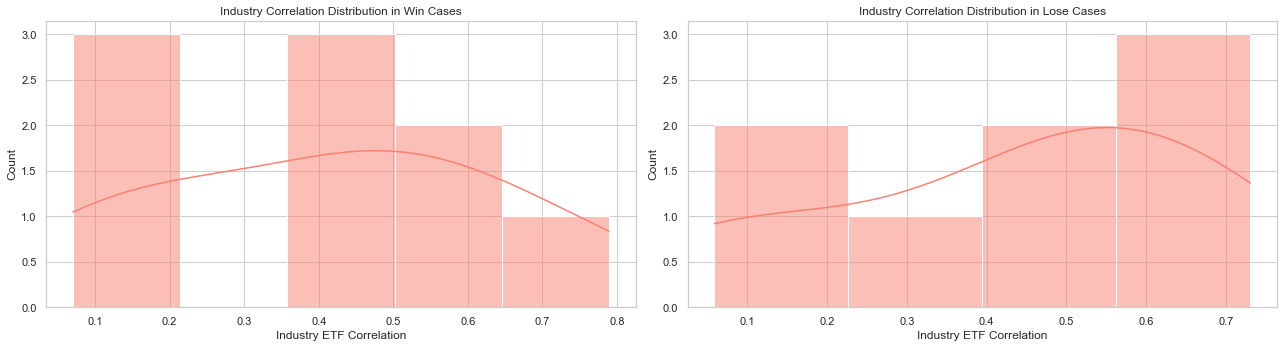

In [35]:
plot_correlation_distribution(win_with_corr_industry, lose_with_corr_industry, level='Industry',
                              save_path="../modelling_result/plot_etf_industry_distribution.png")

#### b. Technical Analysis

In [36]:
def compute_spread_volatility(price1, price2):
    spread = price1 - price2
    return spread.std()

def compute_liquidity_ratio(volume1, volume2):
    return (volume1 / volume2).mean()

def compute_volatility_ratio(price1, price2):
    returns1 = price1.pct_change().dropna()
    returns2 = price2.pct_change().dropna()
    return returns1.std() / returns2.std()


def analyze_technical_features(pair_df, price_df, volume_df):
    """
    price_data_dict: dict of {ticker: price_series}
    volume_data_dict: dict of {ticker: volume_series}
    """
    results = []
    
    for idx, row in pair_df.iterrows():
        s1, s2 = row['Stock1'], row['Stock2']
        p1, p2 = price_df[s1].reset_index(drop=True), price_df[s2].reset_index(drop=True)
        v1, v2 = volume_df[s1].reset_index(drop=True), volume_df[s2].reset_index(drop=True)

        # Align by date
        df = pd.concat([p1, p2, v1, v2], axis=1).dropna()
        price1, price2 = df.iloc[:,0], df.iloc[:,1]
        vol1, vol2 = df.iloc[:,2], df.iloc[:,3]

        spread_volatility = compute_spread_volatility(price1, price2)
        liquidity_diff = compute_liquidity_ratio(vol1, vol2)
        volatility_ratio = compute_volatility_ratio(price1, price2)

        results.append({
            'Stock1': s1,
            'Stock2': s2,
            'Spread_Volatility': spread_volatility,
            'Liquidity_Diff': liquidity_diff,
            'Volatility_Ratio': volatility_ratio
        })

    return pd.DataFrame(results)


In [37]:
volume_df = pd.read_csv(f"../data_prices/volume_2010_2019.csv")

In [38]:
win_technical = analyze_technical_features(win_with_metadata, prices, volume_df)
win_technical.describe()

,Spread_Volatility,Liquidity_Diff,Volatility_Ratio
count,10.000000,10.000000,10.000000
mean,0.289272,inf,2.283475
std,0.247043,NaN,2.382258
min,0.099082,0.816417,0.659772
25%,0.136346,5.717901,1.324429
50%,0.191133,17.960743,1.445211
75%,0.287708,94.835117,1.654195
max,0.825979,inf,8.713013


In [39]:
lose_technical = analyze_technical_features(lose_with_metadata, prices, volume_df)
lose_technical.describe()

,Spread_Volatility,Liquidity_Diff,Volatility_Ratio
count,10.000000,10.000000,10.000000
mean,0.225118,48.058357,0.685431
std,0.083634,77.642561,0.222623
min,0.103491,0.490178,0.377811
25%,0.174890,9.934899,0.523641
50%,0.214994,13.980697,0.661383
75%,0.248848,41.687344,0.853842
max,0.400317,253.131720,1.076398


In [40]:
# Create combined table
win_stats = win_technical.describe()
lose_stats = lose_technical.describe()
combined_table = pd.DataFrame({
    ('Winning cases', 'Spread_Volatility'): win_stats['Spread_Volatility'],
    ('Winning cases', 'Liquidity_Diff'): win_stats['Liquidity_Diff'],
    ('Winning cases', 'Volatility_Ratio'): win_stats['Volatility_Ratio'],
    ('Losing cases', 'Spread_Volatility'): lose_stats['Spread_Volatility'],
    ('Losing cases', 'Liquidity_Diff'): lose_stats['Liquidity_Diff'],
    ('Losing cases', 'Volatility_Ratio'): lose_stats['Volatility_Ratio'],
})

# Format infinity and NaN values
combined_table = combined_table.replace([np.inf, -np.inf], 'inf')
combined_table = combined_table.fillna('NaN')

combined_table

Winning cases                                      Losing cases  \
      Spread_Volatility Liquidity_Diff Volatility_Ratio Spread_Volatility   
count         10.000000           10.0        10.000000         10.000000   
mean           0.289272            inf         2.283475          0.225118   
std            0.247043            NaN         2.382258          0.083634   
min            0.099082       0.816417         0.659772          0.103491   
25%            0.136346       5.717901         1.324429          0.174890   
50%            0.191133      17.960743         1.445211          0.214994   
75%            0.287708      94.835117         1.654195          0.248848   
max            0.825979            inf         8.713013          0.400317   

                                       
      Liquidity_Diff Volatility_Ratio  
count      10.000000        10.000000  
mean       48.058357         0.685431  
std        77.642561         0.222623  
min         0.490178         0.377811  
25%         9.934899         0.523641  
50%        13.980697         0.661383  
75%        41.687344         0.853842  
max       253.131720         1.076398